In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Загрузка необходимых библиотек**

In [30]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2 

**Подготовка датасета**

In [31]:
def Create_Directory_DataFrame():
    df =pd.DataFrame(columns=['Class','Path'])
    basedir = '../input/leapgestrecog/leapGestRecog/'
    for folder in os.listdir(basedir):
        for Class in os.listdir(basedir+folder+'/'):
            for location in os.listdir(basedir+folder+'/'+Class+'/'):
                df_2 = pd.DataFrame({'Class':[Class],'Path':[basedir+folder+'/'+Class+'/'+location]})
                df = pd.concat([df,df_2],axis=0)
    return df

In [32]:
df = Create_Directory_DataFrame()
print(df.shape)
df.head(10)


(20000, 2)


,Class,Path
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...
0,02_l,../input/leapgestrecog/leapGestRecog/07/02_l/f...


**Посмотрим на датасет**

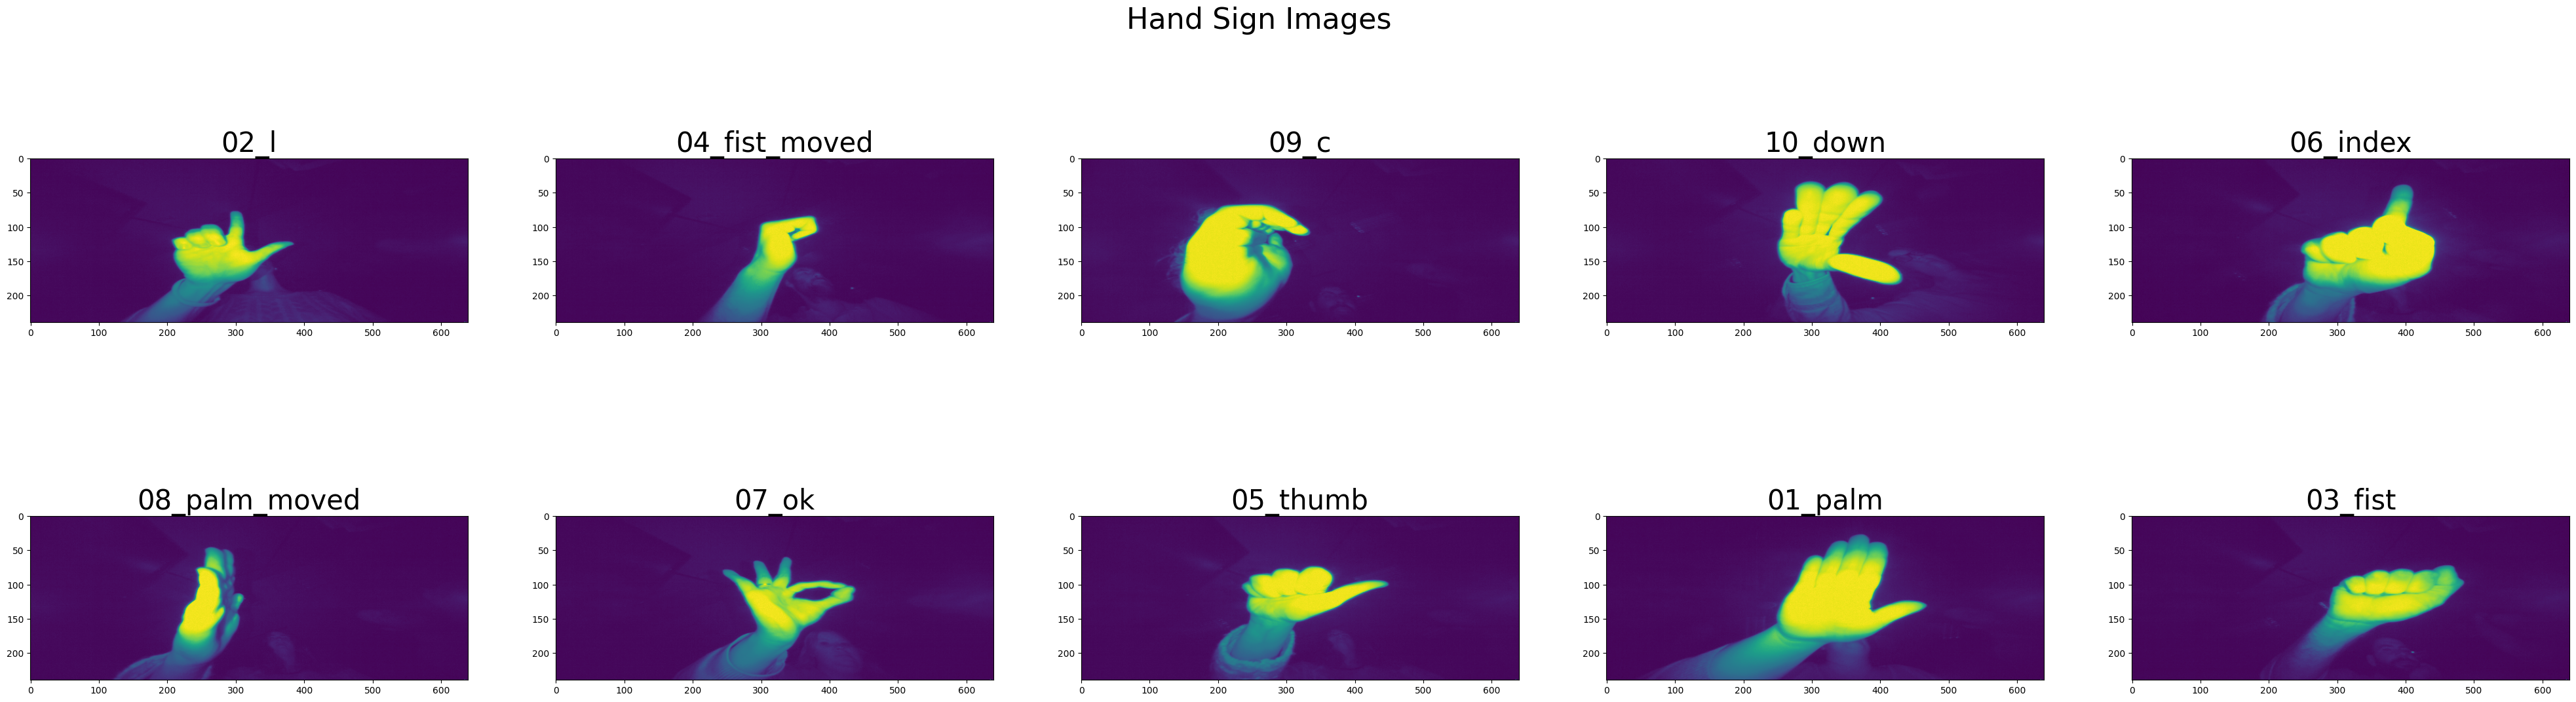

In [33]:
count = 1
f = plt.figure(figsize=(50,13))
for Class in df['Class'].unique():
    seg = df[df['Class']==Class]
    address =  seg.sample().iloc[0]['Path']
    img = cv2.imread(address,0)
    ax = f.add_subplot(2, 5,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()

In [34]:
img.shape

(240, 640)

In [35]:
df['Class'].value_counts()

Class
02_l             2000
04_fist_moved    2000
09_c             2000
10_down          2000
06_index         2000
08_palm_moved    2000
07_ok            2000
05_thumb         2000
01_palm          2000
03_fist          2000
Name: count, dtype: int64

In [36]:
class GestDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataframe: pd.DataFrame, label2indx,
                 transformer, img_column: str = 'Path', label_column: str = 'Class'):
        super().__init__()
        self.transformer = transformer
        self.dataframe = dataframe
        self.img_column = img_column
        self.label_column = label_column
        self.label2indx = label2indx
        self.indx2label = {indx: label for label, indx in self.label2indx.items()}

        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, indx):
        image = cv2.imread(self.dataframe.iloc[indx][self.img_column])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, -1).repeat(3, -1)  #expend dimention to use pretrained model
        image = image / 255
        image = image.astype('float32')
        
        label = self.dataframe.iloc[indx][self.label_column]
        
        if self.transformer:
            sample = self.transformer(image=image)['image']
        
        return torchvision.transforms.ToTensor()(sample.astype('float32')), self.label2indx[label]    

**Разделение датасет на обучение и тест**

In [37]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.25, shuffle=True, stratify=df['Class'])
train_df.head(2)

,Class,Path
0,07_ok,../input/leapgestrecog/leapGestRecog/01/07_ok/...
0,01_palm,../input/leapgestrecog/leapGestRecog/06/01_pal...


**Создадим объекты для необходимых трансформаций нашего датасета, а также сам dataset и обернем его в dataloader**

In [38]:
import albumentations as alb

train_transformer = alb.Compose([
    alb.Resize(height=256, width=256),
    alb.RandomCrop(height=224, width=224),
    alb.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.5, rotate_limit=10, p=1, border_mode=cv2.BORDER_CONSTANT),
    alb.ColorJitter (brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, always_apply=True),
    alb.RandomGamma()
])

running_trainsformer = alb.Compose([
    alb.Resize(height=224, width=224)
])

LABEL2INDX = {label: int(label.split('_')[0]) - 1 for label in df['Class'].unique()}

train_dataset = GestDataset(dataframe=train_df, transformer=train_transformer, label2indx=LABEL2INDX)
train_loader = torch.utils.data.dataloader.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

valid_dataset = GestDataset(dataframe=valid_df, transformer=running_trainsformer, label2indx=LABEL2INDX)
valid_loader = torch.utils.data.dataloader.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

Size torch.Size([3, 224, 224])


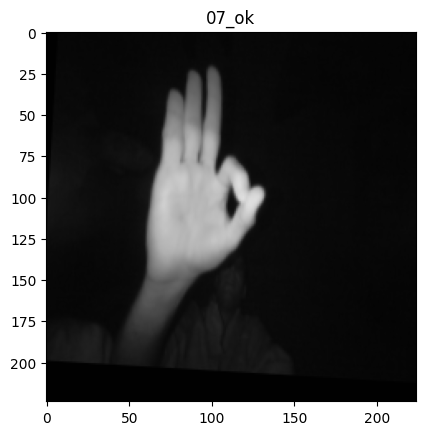

In [39]:
for img, label in train_dataset:
    print('Size', img.shape)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(train_dataset.indx2label[label])
    plt.show()
    break

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [41]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 224, 224])


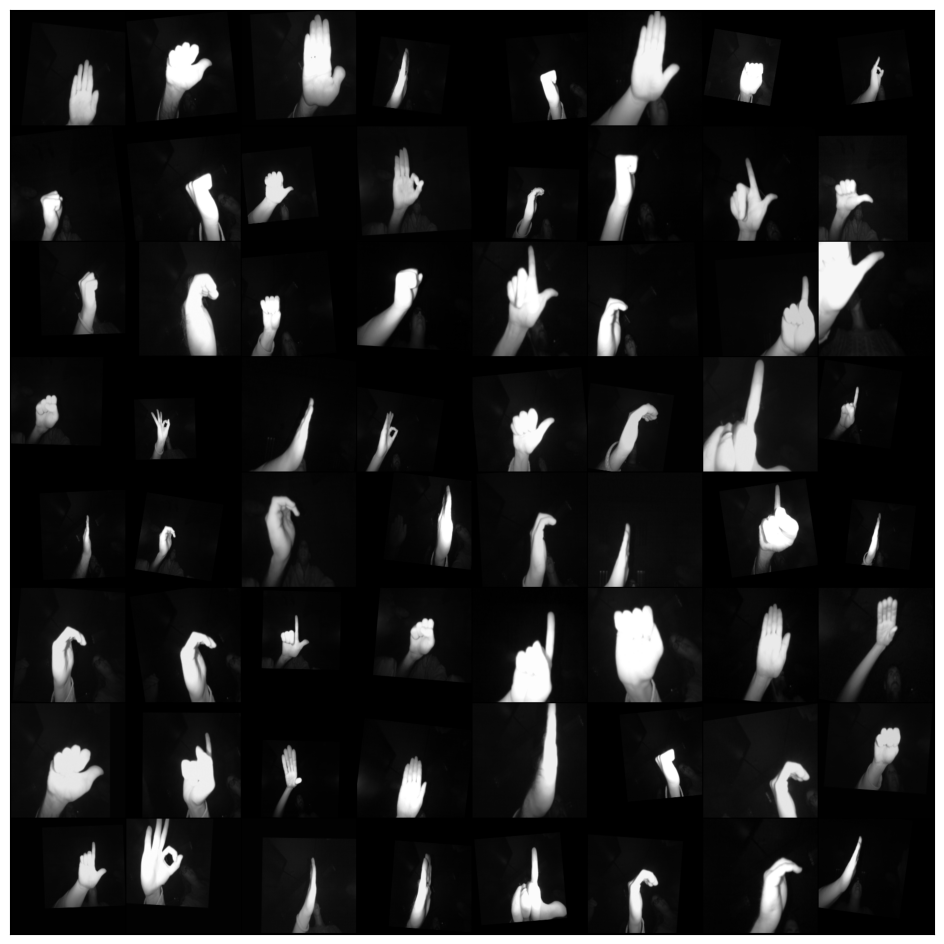

In [42]:
show_batch(train_loader)

In [43]:
from torchvision import models

In [44]:
!pip install torchsummary 

ERROR: Could not find a version that satisfies the requirement torchsummary (from versions: none)
ERROR: No matching distribution found for torchsummary


**Построение и обучение модели**

In [45]:
from time import time
from tqdm import tqdm
import tqdm.notebook as tq

def train(model, criterion, optimizer, train_dataloader, test_dataloader, print_every, num_epoch):
    
    steps = 0
    train_losses, val_losses = [], []
     
    
    model.to(device)
    for epoch in tq.tqdm(range(num_epoch), desc='epoch',position=0):
        running_loss = 0
        correct_train = 0
        total_train = 0

        model.train()
        for i, (images, labels) in tq.tqdm(enumerate(train_dataloader), 
                                        desc='Progress', 
                                        total=len(train_dataloader), 
                                        position=1):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)
            
            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)
        
    return model, train_losses, val_losses

In [46]:
class GestRecogBlock(torch.nn.Module):
    def __init__(self, in_features, out_features, kernel_size=(3, 3), pool_size=2, drop_out=0.3):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=in_features, 
                              out_channels=int(out_features / 2), 
                              kernel_size=kernel_size, padding='same')
        
        self.conv_2 = nn.Conv2d(in_channels=int(out_features / 2), 
                              out_channels=out_features, 
                              kernel_size=kernel_size, padding='same')
        
        torch.nn.init.kaiming_normal_(self.conv_1.weight)
        torch.nn.init.kaiming_normal_(self.conv_2.weight)

        self.max_pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.bn = nn.BatchNorm2d(num_features=out_features)
        self.drop_out = nn.Dropout2d(drop_out)
        

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.bn(x)
        x = self.max_pool(x)
        return x

class GestRecogNN(torch.nn.Module):
    def get_dense_block(self, input_features, out_features, p_dropout):
        return nn.Sequential(
            nn.Linear(input_features, out_features), 
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(p_dropout)
        )
            
    def __init__(self, in_features, out_features):
        super().__init__()
        self.base_block = GestRecogBlock(in_features=in_features, out_features=64)
        self.base_block_2 = GestRecogBlock(in_features=64, out_features=128)
        self.base_block_3 = GestRecogBlock(in_features=128, out_features=256)
        self.base_block_4 = GestRecogBlock(in_features=256, out_features=512)
        self.classifier = nn.Sequential(
            self.get_dense_block(input_features=100352, out_features=256, p_dropout=0.2),
            self.get_dense_block(input_features=256, out_features=128, p_dropout=0.2),
            nn.Linear(in_features=128, out_features=out_features), 
            nn.ReLU())
        
    def forward(self, x):
        x = self.base_block(x)
        x = self.base_block_2(x)
        x = self.base_block_3(x)
        x = self.base_block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = GestRecogNN(in_features=3, out_features=10).to(device)

model, train_losses, val_losses = train(
    model=model,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=100,
    num_epoch=5
)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Progress:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [1]/[5]. Batch [100]/[235]. Train loss 1.829. Train acc 38.109. 

**Сохраняем модель**

In [ ]:
torch.save(model, 'final_model')

**Посмотрим на нашу ошибку в процессе обучения**

In [ ]:
losses = [np.mean(loss) for loss in train_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')

**Посмотрим на нашу ошибку в процессе валидации**

In [ ]:
losses = [np.mean(loss) for loss in val_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')

In [ ]:
net = torch.load('final_model')
net.eval()

In [ ]:
valid_df.head(3)

**Прогоним нашу нейронную сеть через тестовый датасет**

In [ ]:
with torch.no_grad():
    for i, data in enumerate(valid_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(images)
        plt.title(f'pred - {(outputs[0].argmax())}, true_label - {(labels[0])}')
        plt.imshow(images[0].permute(1, 2, 0).cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

**Как видно по тестовым изображениям, модель ни разу не ошиблась.Обученная модель на распознавание жестов имеет точность на валидации Val acc 99.120**